Navigate to the minorminer project root

In [1]:
cd ~/Projects/minorminer/

/home/shannie/Projects/minorminer


In [2]:
from collections import Counter
from itertools import product
import math

import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt

import minorminer.layout as mml

In [3]:
S = nx.random_regular_graph(3, 150)
C = dnx.chimera_graph(13)
P = dnx.pegasus_graph(13)

# Layouts
---
In general, we define a *layout* of $G$ to be a map 
$$f_G: V(G) \to \mathbb R^d$$

# p_norm
---
A Kamada-Kawai-esque layout is calculated.
$$\min_{f_S} \sum_{u, v \in {S \choose 2}} \bigg(d_S \Big(u, v \Big) - d_{\mathbb R^d} \Big(f_S(u), f_S(v) \Big)\bigg)^2$$

#### Parameters
- p: This changes the $p$-norm used in $d_{\mathbb R^d}$.

Set the norms you would like to test

In [4]:
norms = list(range(1,5)) + [float("inf")]

In [5]:
p_norm = {i: mml.p_norm(S, p=i) for i in norms}

# pca
---
First embeds a graph in an $m$-dimensional space using the graph distance. It then projects to a $d$-dimensional space using principal component analysis.

In [6]:
pca = mml.pca(S)

Draw some pictures

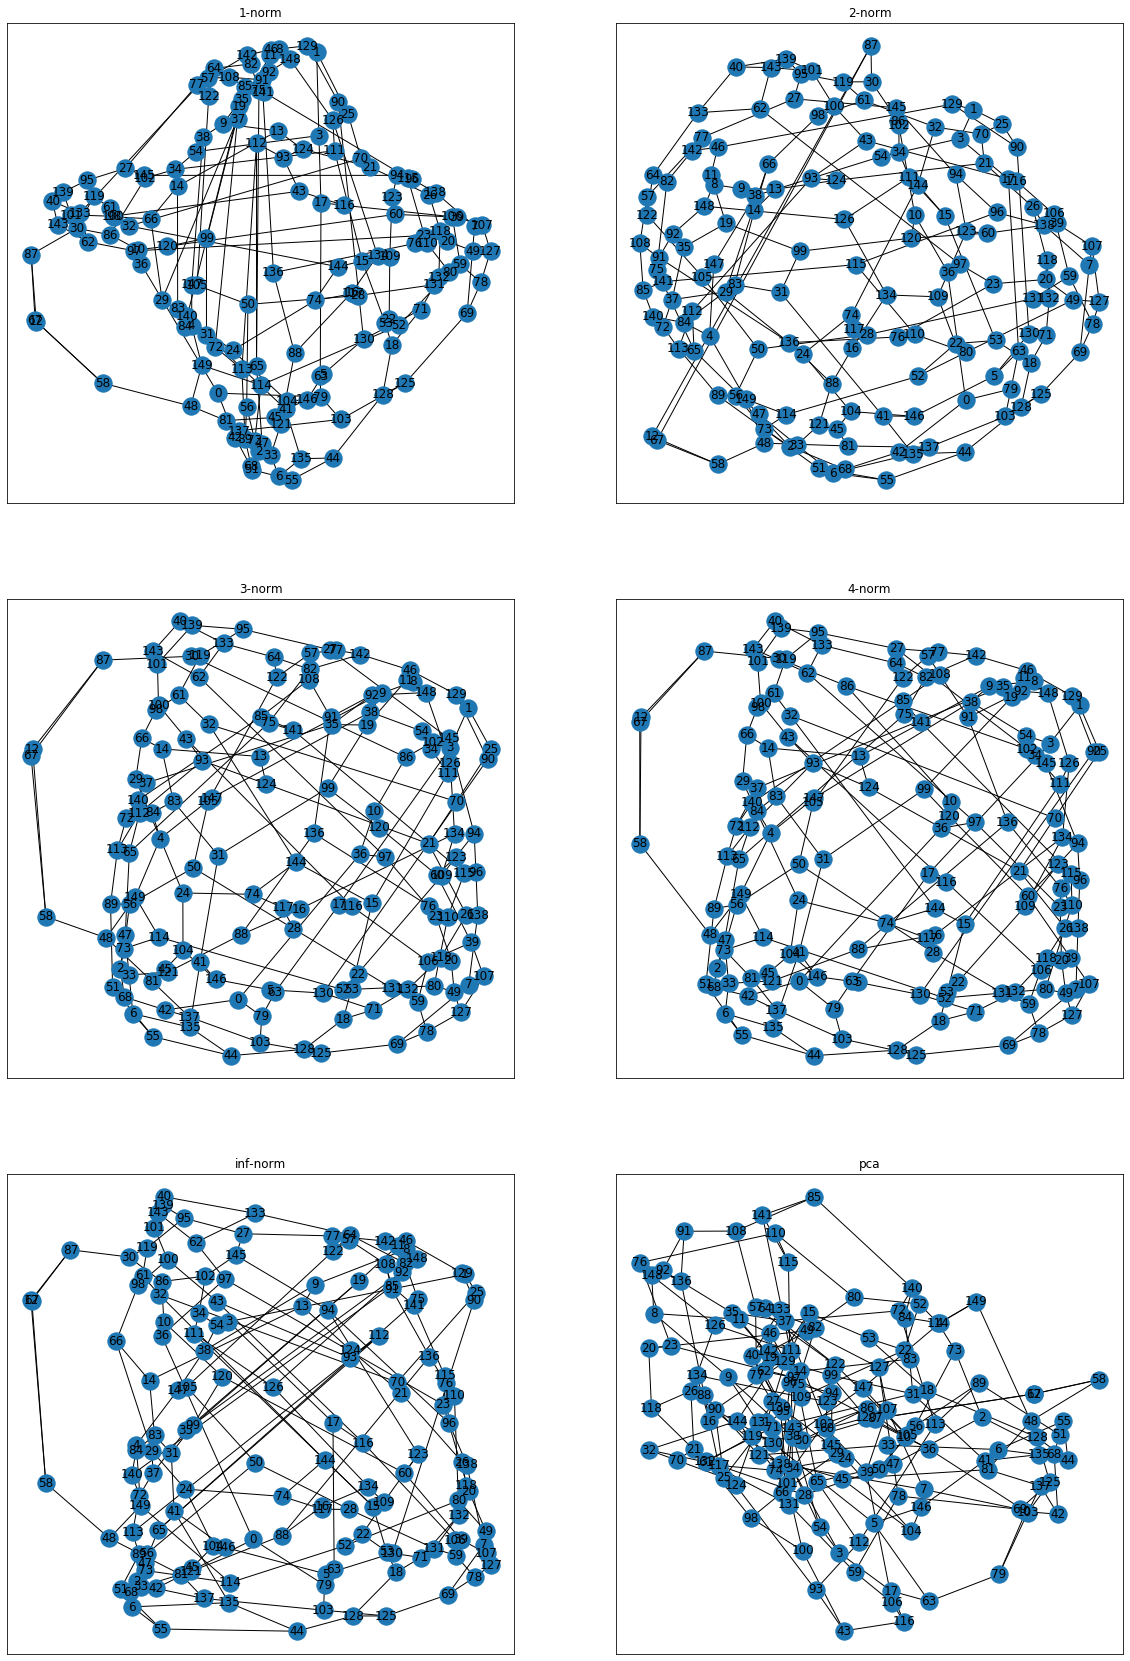

In [7]:
rows = math.ceil((len(norms)+1)/2)
fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))

# Plot p_norms
for i, (p, layout) in enumerate(p_norm.items()):
    axis = axs[int(i/2)][i%2]
    nx.draw_networkx(S, pos=layout, ax=axis)
    axis.title.set_text(f"{p}-norm")

# Plot pca
axis = axs[-1][-1]
nx.draw_networkx(S, pos=pca, ax=axis)
axis.title.set_text("pca")

# Placement
---
In general, we define a *placement* to be a map 
$$\phi: V(S) \to 2^{V(T)}$$

Set the layout from above that you would like to visualize the placement of

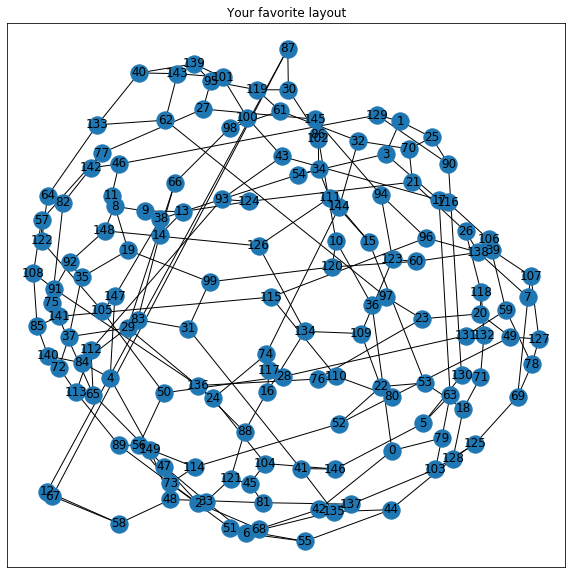

In [8]:
layout = p_norm[2]
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(S, pos=layout)
ax.title.set_text("Your favorite layout")

# closest
---
With the default parameters, this algorithm maps each vertex $u$ in $S$, to some $v$ in $T$ that minimizes $\|f_S(u) - f_T(v)\|_2$ (where $f_S$ and $f_T$ are taken from the layouts above).

#### Parameters
- num_neighbors: This is the number of points from $f_T(T)$ to check before assigning some $u$ in $S$ to $v$ in $T$. Increasing this decreases the overlap.
- max_subset_sizes: This allows the algorithm to consider larger sets than singletons from $V(T)$. A subset $X \subseteq V(T)$ is represented by the centroid of the points that comprise $X$. I.e. $f_T$ is extended so that $f_T: 2^{V(T)} \to \mathbb R^d$ and $f_T(X) = \text{centroid}(\{f_T(v)| v \in X\})$.

Set the parameters you would like to visualize

In [9]:
max_subset_sizes = [(1,1), (1,2), (2,3)]
num_neighbors = [1, 20]

In [10]:
closest = {
    (neighbors, subsets): mml.closest(
        layout, 
        C, 
        max_subset_size=subsets,
        num_neighbors=neighbors
    ) for subsets, neighbors in product(max_subset_sizes, num_neighbors)
}

Draw some pictures

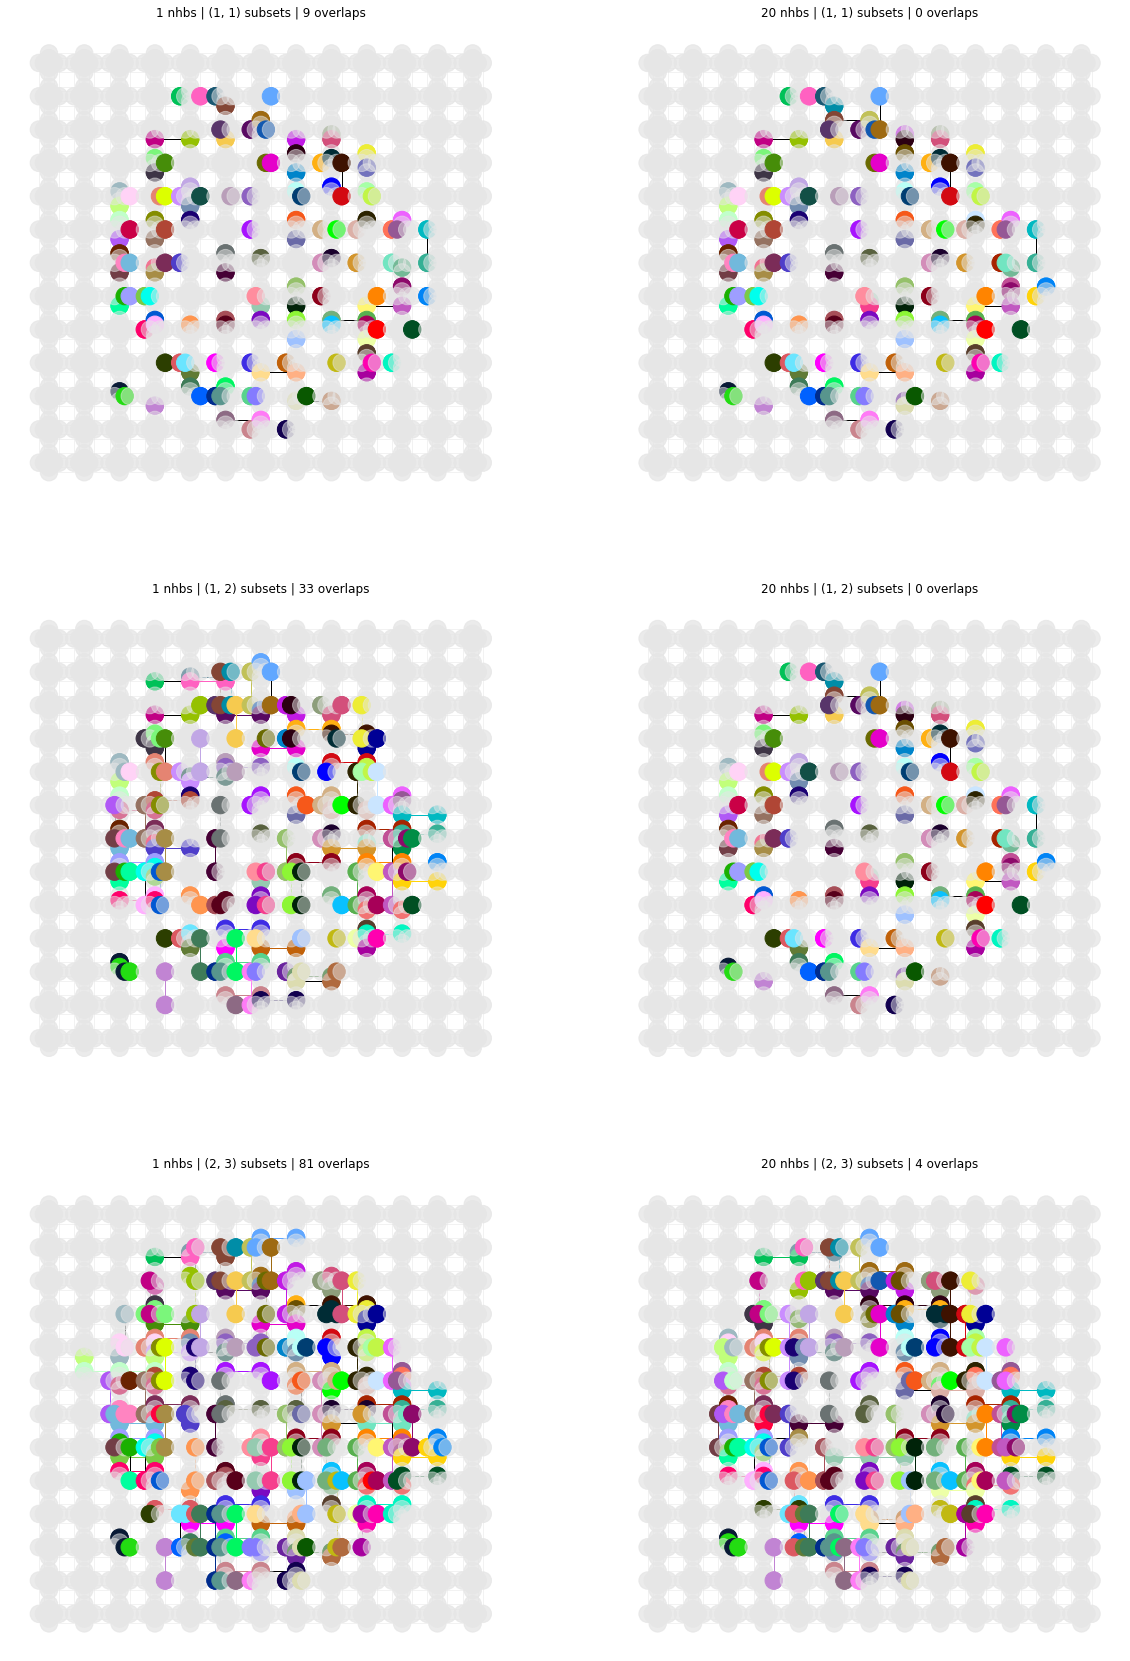

In [11]:
rows = math.ceil((len(list(product(max_subset_sizes, num_neighbors))))/2)
fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))

for i, ((neighbors, subsets), placement) in enumerate(closest.items()):
    axis = axs[int(i/2)][i%2]
    dnx.draw_chimera_embedding(
        C, 
        placement,
        S,
        ax=axis,
        show_labels=False,
        unused_color=(.9,.9,.9,.5),
    )
    overlaps = len([x for x, val in Counter(x for X in placement.values() for x in X).items() if val > 1])
    axis.title.set_text(f"{neighbors} nhbs | {subsets} subsets | {overlaps} overlaps")

# Intersection
---
One can think of a Chimera or Pegasus as discretizations of the plane where vertical and horizontal columns and rows of qubits form grid lines. An intersection of a pair of these grid lines corresponds to a pair of qubits. We consider the union of these intersection points as a subset of the integer lattice $\mathbb Z^2$. This placement algorithm maps each $u$ in $S$ to the lattice point $(x, y)$ that that minimizes $\|f_S(u) - (x, y)\|_2$. 

#### Parameters
- fill_processor: This scales $f_S$ so that it fill the same space as the processor, or not.

In [14]:
intersection = {
    "fill": mml.intersection(layout, C),
    "dont_fill": mml.intersection(layout, C, fill_processor=False)
}

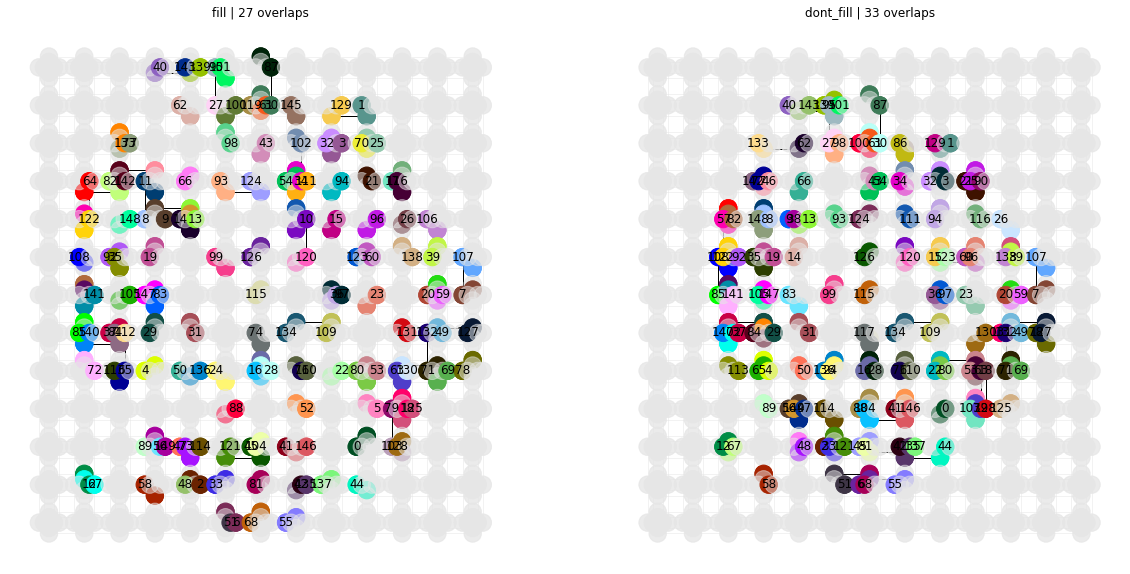

In [16]:
rows = 1
fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))
axs = [axs]

for i, (name, placement) in enumerate(intersection.items()):
    axis = axs[int(i/2)][i%2]
    dnx.draw_chimera_embedding(
        C, 
        placement,
        S,
        ax=axis,
        show_labels=True,
        unused_color=(.9,.9,.9,.5),
    )
    overlaps = len([x for x, val in Counter(x for X in placement.values() for x in X).items() if val > 1])
    axis.title.set_text(f"{name} | {overlaps} overlaps")